In [135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim


In [136]:

file_path='/content/datafile.xlsx'
data_at_admission = pd.read_excel(file_path,sheet_name='Data-at-admission')
hlos = pd.read_excel(file_path,sheet_name='Hospital-length-of-stay')
hospital_df = pd.merge(left=data_at_admission,right=hlos[['parent_id','hospital_length_of_stay']],left_on='id',right_on='parent_id',how='left')


In [137]:
hospital_df.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,...,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp,parent_id,hospital_length_of_stay
0,1,Fever [R50.9],74,Male,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dement...",...,NaN,NaN,NaN,1.1,NaN,NaN,223.0,NaN,1,21
1,2,Pneumonia [J18.9],61,Female,"""[]""",NaN,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Dive...",...,NaN,NaN,NaN,1.0,NaN,2354,95.6,NaN,2,5
2,3,Pneumonia [J18.9],58,Female,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\""]""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,7
3,4,Suspected COVID-19 virus infection [U07.2],94,Male,"""[]""",NaN,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostat...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,9
4,5,"Febrile respiratory illness [J98.9, R50.9]",91,Male,"""[]""",NaN,NaN,NaN,"""[\""Chronic cardiac disease (not hypertension)...","TAVI, Atrial fibrillation, Gastric Reflux, Pac...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,9


In [138]:
hospital_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 57 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                508 non-null    int64  
 1   reason_for_admission              508 non-null    object 
 2   age                               508 non-null    int64  
 3   sex                               508 non-null    object 
 4   ethnicity                         508 non-null    object 
 5   ethnicity_other                   0 non-null      float64
 6   height                            272 non-null    float64
 7   weight                            358 non-null    float64
 8   comorbidities                     508 non-null    object 
 9   comorbidities_other               404 non-null    object 
 10  received_covid_vaccine            1 non-null      object 
 11  covid_vaccine                     0 non-null      float64
 12  medicati

In [139]:
temp = """The variables age, sex, height, weight, comorbidities, comorbidities_other, systolic_blood_pressure, diastolic_blood_pressure, heart_rate, respiratory_rate, oxygen_saturation, temperature, motor, verbal, eye, wbc, rbc, hemoglobin, hematocrit, mcv, mch, mchc, rdw, platelet_count, aptt_aptr, pt, alt, ast, serum_creatinine, sodium, potassium, total_serum_bilirubin, lactate, pao2, pao2_fio2, ph, high_senstivity_cardiac_troponin, esr, inr, ferritin, d_dimer, crp, hs_crp, intubated, hospital_length_of_stay"""
variables = [var.strip() for var in temp.replace("The variables ", "").split(", ")]
variables
hospital_df = hospital_df[variables]
hospital_df.head()

,age,sex,height,weight,comorbidities,comorbidities_other,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,...,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp,intubated,hospital_length_of_stay
0,74,Male,NaN,NaN,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dement...",99,62,85,20,...,NaN,NaN,NaN,1.1,NaN,NaN,223.0,NaN,No,21
1,61,Female,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Dive...",122,77,93,36,...,NaN,NaN,NaN,1.0,NaN,2354,95.6,NaN,No,5
2,58,Female,NaN,NaN,"""[\""Hypertension\""]""",NaN,109,72,73,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,7
3,94,Male,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostat...",165,71,92,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,9
4,91,Male,NaN,NaN,"""[\""Chronic cardiac disease (not hypertension)...","TAVI, Atrial fibrillation, Gastric Reflux, Pac...",131,76,60,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,9


In [140]:
hospital_df.isnull().sum()

,0
age,0
sex,0
height,236
weight,150
comorbidities,0
comorbidities_other,104
systolic_blood_pressure,0
diastolic_blood_pressure,0
heart_rate,0
respiratory_rate,0


In [141]:
hospital_df.nunique()

,0
age,76
sex,2
height,69
weight,203
comorbidities,137
comorbidities_other,359
systolic_blood_pressure,100
diastolic_blood_pressure,65
heart_rate,83
respiratory_rate,28


In [142]:

threshold = 0.3 * 508
hospital_df = hospital_df.dropna(thresh=threshold, axis=1)
hospital_df.head()

,age,sex,height,weight,comorbidities,comorbidities_other,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,...,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,inr,d_dimer,intubated,hospital_length_of_stay
0,74,Male,NaN,NaN,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dement...",99,62,85,20,...,49.0,165.0,135.0,3.9,10.0,2.3,1.1,NaN,No,21
1,61,Female,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Dive...",122,77,93,36,...,68.0,49.0,137.0,3.8,12.0,1.5,1.0,2354,No,5
2,58,Female,NaN,NaN,"""[\""Hypertension\""]""",NaN,109,72,73,24,...,76.0,71.0,135.0,3.7,7.0,1.0,NaN,NaN,No,7
3,94,Male,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostat...",165,71,92,16,...,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,No,9
4,91,Male,NaN,NaN,"""[\""Chronic cardiac disease (not hypertension)...","TAVI, Atrial fibrillation, Gastric Reflux, Pac...",131,76,60,18,...,26.0,109.0,142.0,3.8,19.0,3.2,NaN,NaN,No,9


In [143]:
hospital_df['aptt_aptr'] = pd.to_numeric(hospital_df['aptt_aptr'], errors='coerce')
hospital_df['d_dimer'] = pd.to_numeric(hospital_df['d_dimer'], errors='coerce')

# Convert 'sex' column: map male to 1, female to 0
hospital_df['sex'] = hospital_df['sex'].map({'Male': 1, 'Female': 0})

# Convert 'intubated' column: map yes to 1, no to 0
hospital_df['intubated'] = hospital_df['intubated'].map({'Yes': 1, 'No': 0})

hospital_df.head()

<ipython-input-143-fbc46943c7b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_df['aptt_aptr'] = pd.to_numeric(hospital_df['aptt_aptr'], errors='coerce')
<ipython-input-143-fbc46943c7b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_df['d_dimer'] = pd.to_numeric(hospital_df['d_dimer'], errors='coerce')
<ipython-input-143-fbc46943c7b2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,age,sex,height,weight,comorbidities,comorbidities_other,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,...,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,inr,d_dimer,intubated,hospital_length_of_stay
0,74,1,NaN,NaN,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dement...",99,62,85,20,...,49.0,165.0,135.0,3.9,10.0,2.3,1.1,NaN,0,21
1,61,0,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Dive...",122,77,93,36,...,68.0,49.0,137.0,3.8,12.0,1.5,1.0,2354.0,0,5
2,58,0,NaN,NaN,"""[\""Hypertension\""]""",NaN,109,72,73,24,...,76.0,71.0,135.0,3.7,7.0,1.0,NaN,NaN,0,7
3,94,1,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostat...",165,71,92,16,...,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,0,9
4,91,1,NaN,NaN,"""[\""Chronic cardiac disease (not hypertension)...","TAVI, Atrial fibrillation, Gastric Reflux, Pac...",131,76,60,18,...,26.0,109.0,142.0,3.8,19.0,3.2,NaN,NaN,0,9


In [144]:
num_cols = hospital_df.select_dtypes(include=['float64', 'int64']).columns

knn_cols = ['aptt_aptr', 'pt']
other_numerical_cols = [col for col in num_cols if col not in knn_cols]
hospital_df[other_numerical_cols] = hospital_df[other_numerical_cols].fillna(hospital_df[other_numerical_cols].median())
epochee = lambda num: (num + 5) * 10
catageroical_cols = hospital_df.select_dtypes(include=['object']).columns
hospital_df[catageroical_cols] = hospital_df[catageroical_cols].fillna(hospital_df[catageroical_cols].mode().iloc[0])

<ipython-input-144-b1a8f9e58e1b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_df[other_numerical_cols] = hospital_df[other_numerical_cols].fillna(hospital_df[other_numerical_cols].median())
<ipython-input-144-b1a8f9e58e1b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_df[catageroical_cols] = hospital_df[catageroical_cols].fillna(hospital_df[catageroical_cols].mode().iloc[0])


In [145]:

null_values_after_imputation =hospital_df.isnull().sum()


print("Null values after KNN and median/mode imputation:\n", null_values_after_imputation)

Null values after KNN and median/mode imputation:
 age                           0
sex                           0
height                        0
weight                        0
comorbidities                 0
comorbidities_other           0
systolic_blood_pressure       0
diastolic_blood_pressure      0
heart_rate                    0
respiratory_rate              0
oxygen_saturation             0
temperature                   0
motor                         0
verbal                        0
eye                           0
wbc                           0
rbc                           0
hemoglobin                    0
hematocrit                    0
mcv                           0
mch                           0
mchc                          0
rdw                           0
platelet_count                0
aptt_aptr                   221
pt                          193
alt                           0
ast                           0
serum_creatinine              0
sodium               

In [146]:

numerical_means = hospital_df.drop(columns=['sex', 'intubated']).select_dtypes(include=['number']).mean()
epochee = lambda num: (num + 5) * 10
categorical_unique_values = hospital_df.drop(columns=['sex', 'intubated']).select_dtypes(include=['object', 'category']).nunique()
sex_counts = hospital_df['sex'].value_counts().rename(index={1: 'Male', 0: 'Female'})

intubated_counts = hospital_df['intubated'].value_counts().rename(index={1: 'Yes', 0: 'No'})

In [147]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)  # Using 5 neighbors by default

hospital_df[knn_cols] = knn_imputer.fit_transform(hospital_df[knn_cols])

In [148]:
hospital_df.head()

,age,sex,height,weight,comorbidities,comorbidities_other,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,...,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,inr,d_dimer,intubated,hospital_length_of_stay
0,74,1,167.6,76.7,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dement...",99,62,85,20,...,49.0,165.0,135.0,3.9,10.0,2.3,1.1,1018.0,0,21
1,61,0,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Dive...",122,77,93,36,...,68.0,49.0,137.0,3.8,12.0,1.5,1.0,2354.0,0,5
2,58,0,167.6,76.7,"""[\""Hypertension\""]""",Dyslipidemia,109,72,73,24,...,76.0,71.0,135.0,3.7,7.0,1.0,1.0,1018.0,0,7
3,94,1,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostat...",165,71,92,16,...,24.0,146.0,135.0,2.8,10.0,4.5,1.0,1018.0,0,9
4,91,1,167.6,76.7,"""[\""Chronic cardiac disease (not hypertension)...","TAVI, Atrial fibrillation, Gastric Reflux, Pac...",131,76,60,18,...,26.0,109.0,142.0,3.8,19.0,3.2,1.0,1018.0,0,9


In [149]:
hospital_df.nunique()

,0
age,76
sex,2
height,69
weight,204
comorbidities,137
comorbidities_other,359
systolic_blood_pressure,100
diastolic_blood_pressure,65
heart_rate,83
respiratory_rate,28


In [150]:
def preprocess_text(text):
    # Preprocess comorbidities text (you can adjust based on your data)
    return text.lower().split()

hospital_df['comorbidities_processed'] = hospital_df['comorbidities_other'].apply(preprocess_text)

word2vec_model = Word2Vec(sentences=hospital_df['comorbidities_processed'], vector_size=50, window=5, min_count=1, workers=4)
hospital_df['comorbidities_vec'] = hospital_df['comorbidities_processed'].apply(lambda x: np.mean([word2vec_model.wv[word] for word in x if word in word2vec_model.wv], axis=0))

hospital_df = hospital_df.dropna(subset=['comorbidities_vec'])



In [151]:
hospital_df.head()
hospital_df.isnull().sum()

,age,sex,height,weight,comorbidities,comorbidities_other,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,...,sodium,potassium,total_serum_bilirubin,lactate,inr,d_dimer,intubated,hospital_length_of_stay,comorbidities_processed,comorbidities_vec
0,74,1,167.6,76.7,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dement...",99,62,85,20,...,135.0,3.9,10.0,2.3,1.1,1018.0,0,21,"[gerd, (gastroesophageal, reflux, disease),, d...","[-0.0019518099, 0.00044901887, 0.004173615, -0..."
1,61,0,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Dive...",122,77,93,36,...,137.0,3.8,12.0,1.5,1.0,2354.0,0,5,"[closed, fracture, of, fifth, metatarsal, bone...","[0.0049844757, 0.006182187, -0.0023723156, 0.0..."
2,58,0,167.6,76.7,"""[\""Hypertension\""]""",Dyslipidemia,109,72,73,24,...,135.0,3.7,7.0,1.0,1.0,1018.0,0,7,[dyslipidemia],"[-0.0011411794, 0.0004133377, 0.010223488, 0.0..."
3,94,1,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostat...",165,71,92,16,...,135.0,2.8,10.0,4.5,1.0,1018.0,0,9,"[parkinson's, disease,, back, pain,, benign, p...","[-0.0013800903, 0.0044691465, 0.003095696, 0.0..."
4,91,1,167.6,76.7,"""[\""Chronic cardiac disease (not hypertension)...","TAVI, Atrial fibrillation, Gastric Reflux, Pac...",131,76,60,18,...,142.0,3.8,19.0,3.2,1.0,1018.0,0,9,"[tavi,, atrial, fibrillation,, gastric, reflux...","[-0.005155638, -0.008734879, -0.007390146, -0...."


In [152]:

hospital_df = hospital_df.dropna(subset=['comorbidities_vec'])

In [153]:
hospital_df.head()
hospital_df.isnull().sum()

,age,sex,height,weight,comorbidities,comorbidities_other,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,...,sodium,potassium,total_serum_bilirubin,lactate,inr,d_dimer,intubated,hospital_length_of_stay,comorbidities_processed,comorbidities_vec
0,74,1,167.6,76.7,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dement...",99,62,85,20,...,135.0,3.9,10.0,2.3,1.1,1018.0,0,21,"[gerd, (gastroesophageal, reflux, disease),, d...","[-0.0019518099, 0.00044901887, 0.004173615, -0..."
1,61,0,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Dive...",122,77,93,36,...,137.0,3.8,12.0,1.5,1.0,2354.0,0,5,"[closed, fracture, of, fifth, metatarsal, bone...","[0.0049844757, 0.006182187, -0.0023723156, 0.0..."
2,58,0,167.6,76.7,"""[\""Hypertension\""]""",Dyslipidemia,109,72,73,24,...,135.0,3.7,7.0,1.0,1.0,1018.0,0,7,[dyslipidemia],"[-0.0011411794, 0.0004133377, 0.010223488, 0.0..."
3,94,1,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostat...",165,71,92,16,...,135.0,2.8,10.0,4.5,1.0,1018.0,0,9,"[parkinson's, disease,, back, pain,, benign, p...","[-0.0013800903, 0.0044691465, 0.003095696, 0.0..."
4,91,1,167.6,76.7,"""[\""Chronic cardiac disease (not hypertension)...","TAVI, Atrial fibrillation, Gastric Reflux, Pac...",131,76,60,18,...,142.0,3.8,19.0,3.2,1.0,1018.0,0,9,"[tavi,, atrial, fibrillation,, gastric, reflux...","[-0.005155638, -0.008734879, -0.007390146, -0...."


In [154]:
hospital_df.to_csv('preprocessed_data.csv', index=False)

In [155]:
if 'comorbidities_vec' in hospital_df.columns:
    hospital_df = hospital_df.drop(columns=['comorbidities_other'])

In [156]:

def categorize_comorbidities(comorbidity):
    if 'cardiac' in comorbidity:
        return 'Cardiovascular'
    elif 'diabetes' in comorbidity:
        return 'Metabolic'
    elif 'respiratory' in comorbidity:
        return 'Respiratory'
    else:
        return 'Other'

hospital_df['comorbidities_category'] = hospital_df['comorbidities'].apply(categorize_comorbidities)

In [157]:
from sklearn.preprocessing import OneHotEncoder

hospital_df['comorbidities_category'] = hospital_df['comorbidities'].apply(categorize_comorbidities)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
comorbidities_encoded = encoder.fit_transform(hospital_df[['comorbidities_category']])
comorbidities_encoded_df = pd.DataFrame(comorbidities_encoded, columns=encoder.get_feature_names_out(['comorbidities_category']))

hospital_df = hospital_df.drop(columns=['comorbidities'])
hospital_df = pd.concat([hospital_df, comorbidities_encoded_df], axis=1)

In [158]:

numerical_features = hospital_df.select_dtypes(include=['float64', 'int64']).columns
for column in numerical_features:
  hospital_df[column] = hospital_df[column].fillna(hospital_df[column].median())

In [159]:
scaler = StandardScaler()
hospital_df[numerical_features] = scaler.fit_transform(hospital_df[numerical_features])

In [160]:
hospital_df.head()

,age,sex,height,weight,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,...,lactate,inr,d_dimer,intubated,hospital_length_of_stay,comorbidities_processed,comorbidities_vec,comorbidities_category,comorbidities_category_Cardiovascular,comorbidities_category_Other
0,0.486777,0.846296,0.046033,-0.136901,-1.378253,-1.056722,-0.708594,-0.684234,-0.016469,-0.278453,...,0.047269,0.002199,-0.228143,-0.17443,0.720477,"[gerd, (gastroesophageal, reflux, disease),, d...","[-0.0019518099, 0.00044901887, 0.004173615, -0...",Other,-0.457738,0.457738
1,-0.306970,-1.181620,-1.538752,-0.305780,-0.334198,0.111621,-0.251350,1.549282,-0.836679,0.240835,...,-0.709029,-0.183965,2.104986,-0.17443,-0.625120,"[closed, fracture, of, fifth, metatarsal, bone...","[0.0049844757, 0.006182187, -0.0023723156, 0.0...",Other,-0.457738,0.457738
2,-0.490142,-1.181620,0.046033,-0.136901,-0.924316,-0.277826,-1.394461,-0.125855,-0.344553,0.552408,...,-1.181715,-0.183965,-0.228143,-0.17443,-0.456920,[dyslipidemia],"[-0.0011411794, 0.0004133377, 0.010223488, 0.0...",Other,-0.457738,0.457738
3,1.707926,0.846296,1.942784,-0.708911,1.617732,-0.355716,-0.308505,-1.242613,0.475657,-0.278453,...,2.127088,-0.183965,-0.228143,-0.17443,-0.288721,"[parkinson's, disease,, back, pain,, benign, p...","[-0.0013800903, 0.0044691465, 0.003095696, 0.0...",Other,-0.457738,0.457738
4,1.524754,0.846296,0.046033,-0.136901,0.074346,0.033732,-2.137484,-0.963423,0.311615,0.448550,...,0.898104,-0.183965,-0.228143,-0.17443,-0.288721,"[tavi,, atrial, fibrillation,, gastric, reflux...","[-0.005155638, -0.008734879, -0.007390146, -0....",Cardiovascular,2.184657,-2.184657


In [161]:
hospital_df.isnull().sum()
hospital_df.describe()

hospital_df.to_csv('preprocessed_data.csv', index=False)

In [162]:

hospital_df = hospital_df.drop(columns=['comorbidities_processed', 'comorbidities_category'], errors='ignore')

hospital_df.head()

,age,sex,height,weight,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,...,potassium,total_serum_bilirubin,lactate,inr,d_dimer,intubated,hospital_length_of_stay,comorbidities_vec,comorbidities_category_Cardiovascular,comorbidities_category_Other
0,0.486777,0.846296,0.046033,-0.136901,-1.378253,-1.056722,-0.708594,-0.684234,-0.016469,-0.278453,...,0.026926,-0.057389,0.047269,0.002199,-0.228143,-0.17443,0.720477,"[-0.0019518099, 0.00044901887, 0.004173615, -0...",-0.457738,0.457738
1,-0.306970,-1.181620,-1.538752,-0.305780,-0.334198,0.111621,-0.251350,1.549282,-0.836679,0.240835,...,-0.163049,0.333936,-0.709029,-0.183965,2.104986,-0.17443,-0.625120,"[0.0049844757, 0.006182187, -0.0023723156, 0.0...",-0.457738,0.457738
2,-0.490142,-1.181620,0.046033,-0.136901,-0.924316,-0.277826,-1.394461,-0.125855,-0.344553,0.552408,...,-0.353024,-0.644377,-1.181715,-0.183965,-0.228143,-0.17443,-0.456920,"[-0.0011411794, 0.0004133377, 0.010223488, 0.0...",-0.457738,0.457738
3,1.707926,0.846296,1.942784,-0.708911,1.617732,-0.355716,-0.308505,-1.242613,0.475657,-0.278453,...,-2.062794,-0.057389,2.127088,-0.183965,-0.228143,-0.17443,-0.288721,"[-0.0013800903, 0.0044691465, 0.003095696, 0.0...",-0.457738,0.457738
4,1.524754,0.846296,0.046033,-0.136901,0.074346,0.033732,-2.137484,-0.963423,0.311615,0.448550,...,-0.163049,1.703574,0.898104,-0.183965,-0.228143,-0.17443,-0.288721,"[-0.005155638, -0.008734879, -0.007390146, -0....",2.184657,-2.184657


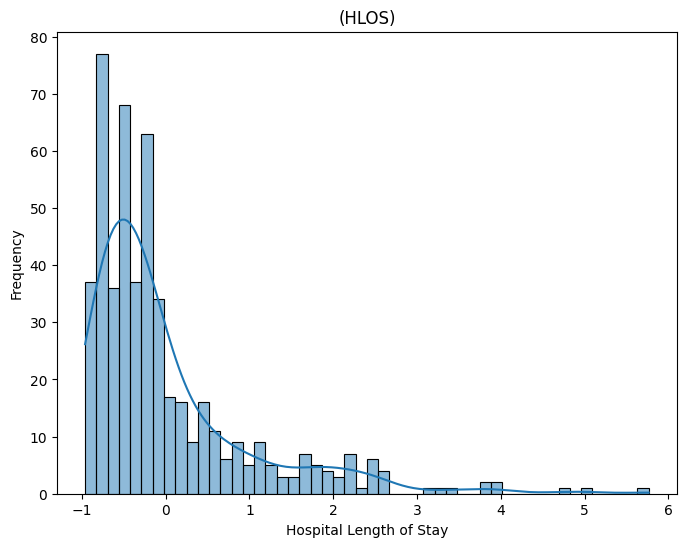

In [163]:

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.histplot(hospital_df['hospital_length_of_stay'], bins=50, kde=True)
plt.title('(HLOS)')
plt.xlabel('Hospital Length of Stay')
plt.ylabel('Frequency')
plt.show()

if hospital_df['hospital_length_of_stay'].skew() > 1:
    hospital_df['log_hlos'] = np.log1p(hospital_df['hospital_length_of_stay'])
    target = 'log_hlos'
else:
    target = 'hospital_length_of_stay'

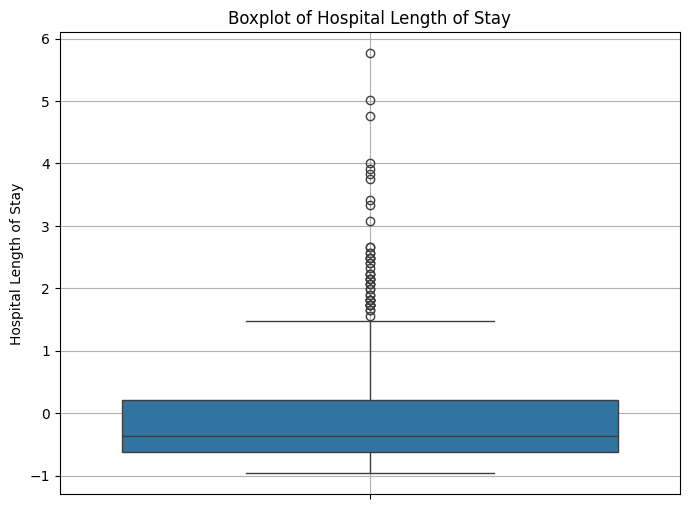

In [173]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=hospital_df, y='hospital_length_of_stay')
plt.title('Boxplot of Hospital Length of Stay')
plt.ylabel('Hospital Length of Stay')
plt.grid(True)
plt.show()


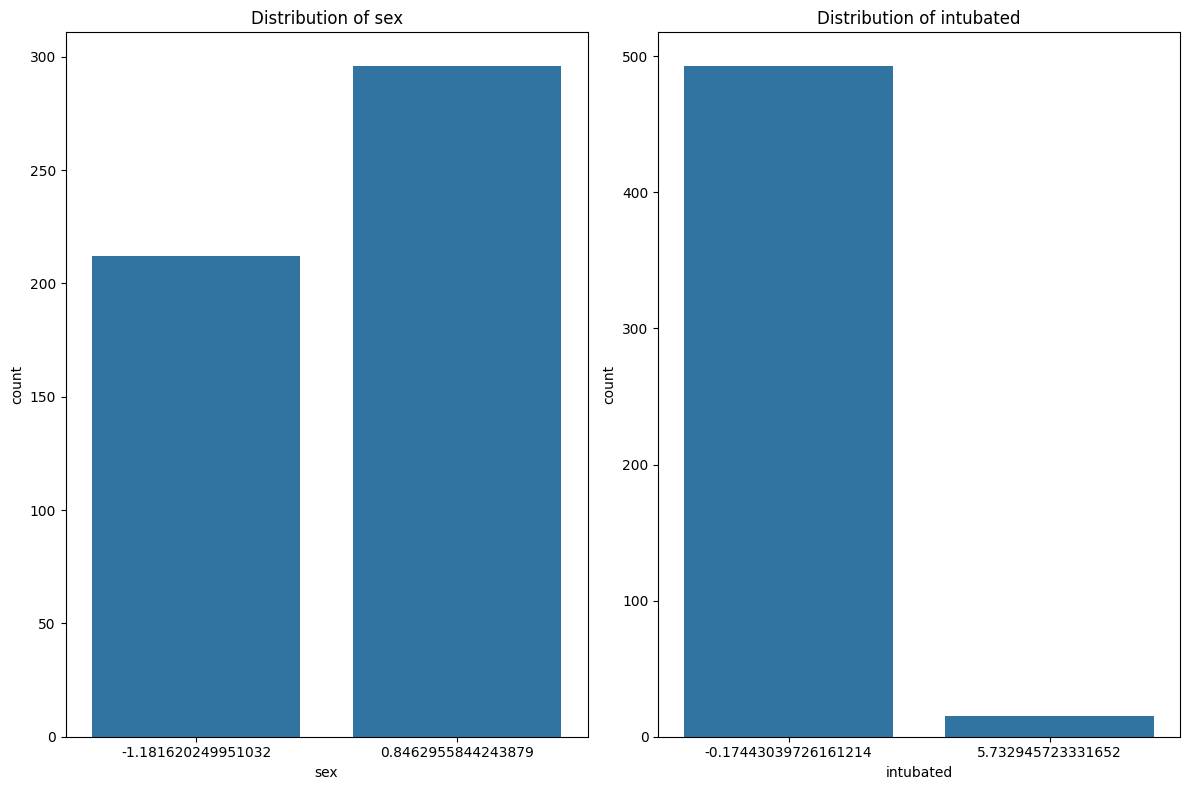

In [176]:
categorical_cols = ['sex', 'intubated']

plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 2, i)
    sns.countplot(x=col, data=hospital_df)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


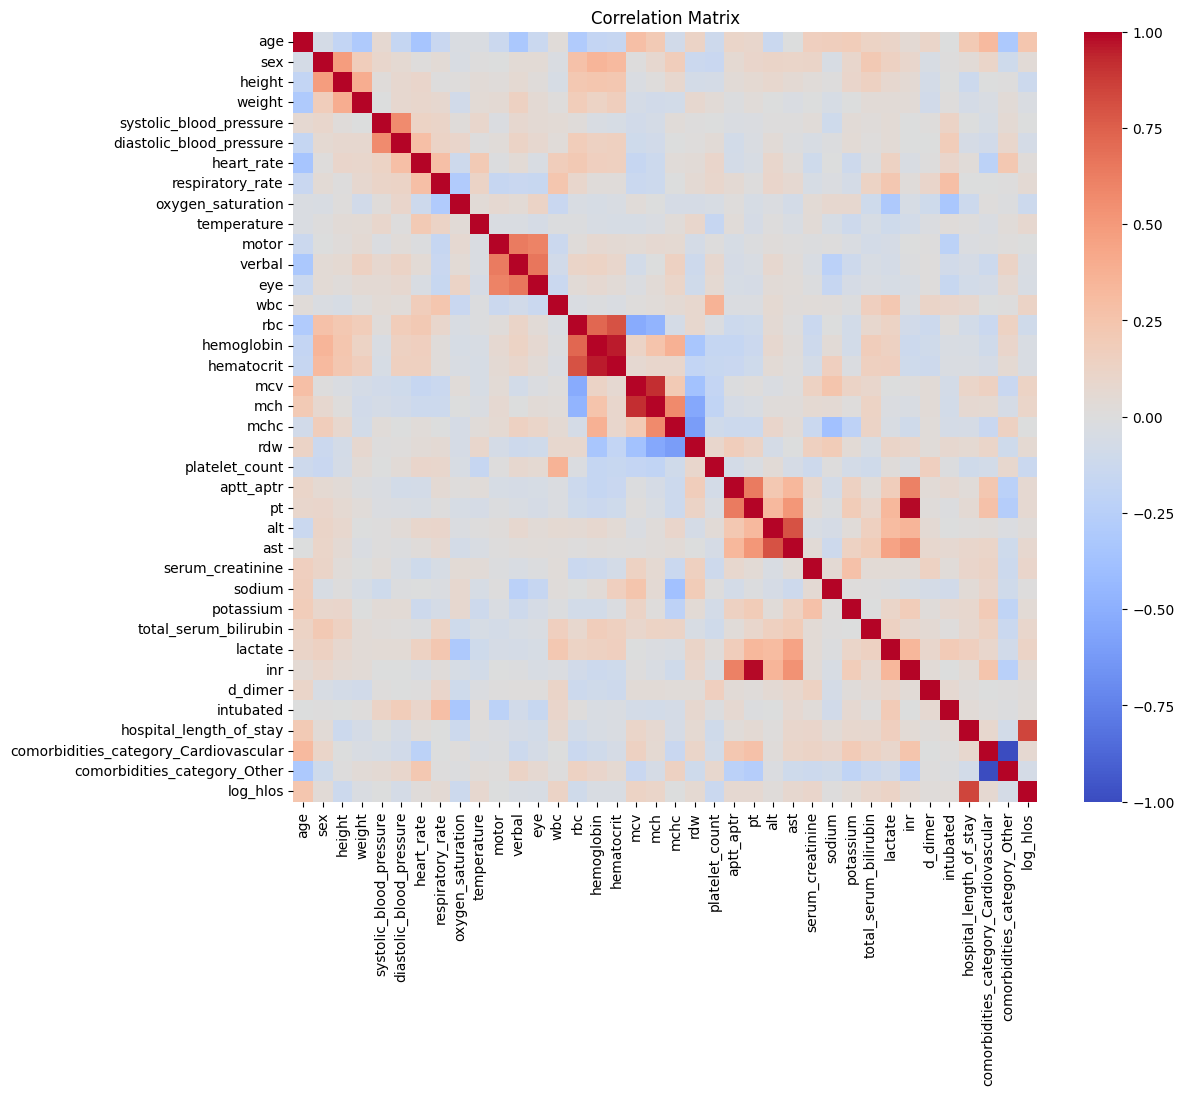

Top features selected based on correlation with target:
['hospital_length_of_stay', 'age', 'platelet_count', 'mcv', 'oxygen_saturation', 'height', 'lactate', 'wbc', 'mch', 'rbc', 'serum_creatinine', 'total_serum_bilirubin', 'ast', 'temperature', 'diastolic_blood_pressure']


In [123]:

import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix = hospital_df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

correlations = corr_matrix[target].abs().sort_values(ascending=False)
high_features = correlations[1:16].index.tolist()

print("Top features selected based on correlation with target:")
print(high_features)

In [124]:
X = hospital_df[high_features]
y = hospital_df[target]

In [125]:
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [126]:

def build_model(input_dim, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate / 2))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate / 4))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    return model

In [127]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [128]:
num_trials = 5
train_mse_list = []
test_mse_list = []

learning_rates = [0.0005, 0.0001]
dropout_rates = [0.1, 0.2]

best_mse = float('inf')
best_params = {}

for lr in learning_rates:
    for dr in dropout_rates:
        print(f"Learning Rate: {lr}, Dropout Rate: {dr}")


        for trial in range(num_trials):
            print(f"Trial {trial + 1}/{num_trials}")

            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=trial)

            model = build_model(input_dim=X_train.shape[1], dropout_rate=dr, learning_rate=lr)


            early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

            trained_model = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2,
                                      callbacks=[early_stopping, reduce_lr], verbose=0)

            y_train_pred = model.predict(X_train).flatten()
            y_test_pred = model.predict(X_test).flatten()


            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)

            train_mse_list.append(train_mse)
            test_mse_list.append(test_mse)

            print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

            if test_mse < best_mse:
                best_mse = test_mse
                best_params = {'learning_rate': lr, 'dropout_rate': dr}

mean_train_mse = np.mean(train_mse_list)
std_train_mse = np.std(train_mse_list)
mean_test_mse = np.mean(test_mse_list)
std_test_mse = np.std(test_mse_list)

print(f"Average Train MSE: {mean_train_mse:.4f}, Std Dev Train MSE: {std_train_mse:.4f}")
print(f"Average Test MSE: {mean_test_mse:.4f}, Std Dev Test MSE: {std_test_mse:.4f}")
print(f"Best Hyperparameters: {best_params}")
print(f"Best Test MSE: {best_mse}")

Learning Rate: 0.0005, Dropout Rate: 0.1
Trial 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train MSE: 0.3035, Test MSE: 0.5017
Trial 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.1429, Test MSE: 0.3667
Trial 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train MSE: 0.1142, Test MSE: 0.4091
Trial 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train MSE: 0.1845, Test MSE: 0.4387
Trial 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.1143, Test MSE: 0.4547
Learning Rate: 0.0005, Dropout Rate: 0.2
Trial 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.1752, Test MSE: 0.4052
Trial 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.1590, Test MSE: 0.3097
Trial 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.0950, Test MSE: 0.2584
Trial 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.2026, Test MSE: 0.3817
Trial 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train MSE: 0.1250, Test MSE: 0.3449
Learning Rate: 0.0001, Dropout Rate: 0.1
Trial 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.8059, Test MSE: 0.8497
Trial 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 1.1220, Test MSE: 0.9571
Trial 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.9866, Test MSE: 0.9753
Trial 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.9953, Test MSE: 1.1612
Trial 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train MSE: 0.4383, Test MSE: 0.7288
Learning Rate: 0.0001, Dropout Rate: 0.2
Trial 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train MSE: 1.1274, Test MSE: 1.1121
Trial 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.8065, Test MSE: 0.8275
Trial 3/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.3706, Test MSE: 1.0958
Trial 4/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train MSE: 0.5793, Test MSE: 0.9979
Trial 5/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.8301, Test MSE: 0.8966
Average Train MSE: 0.4839, Std Dev Train MSE: 0.3714
Average Test MSE: 0.6736, Std Dev Test MSE: 0.3049
Best Hyperparameters: {'learning_rate': 0.0005, 'dropout_rate': 0.2}
Best Test MSE: 0.2584490576315693


In [129]:

final_model = build_model(input_dim=X_train.shape[1], dropout_rate=best_params['dropout_rate'], learning_rate=best_params['learning_rate'])

history = final_model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)
y_test_pred = final_model.predict(X_test).flatten()
if target == 'log_hlos':
    y_test_pred = np.expm1(y_test_pred)
    y_test_actual = np.expm1(y_test)
else:
    y_test_actual = y_test
mse = mean_squared_error(y_test_actual, y_test_pred)
r2 = r2_score(y_test_actual, y_test_pred)

print(f"Final MSE (Test): {mse:.4f}")
print(f"Final R2 score (Test): {r2:.4f}")

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 1.7430 - mse: 1.7430 - val_loss: 1.1034 - val_mse: 1.1034 - learning_rate: 5.0000e-04
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5351 - mse: 1.5351 - val_loss: 1.0165 - val_mse: 1.0165 - learning_rate: 5.0000e-04
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5316 - mse: 1.5316 - val_loss: 0.9486 - val_mse: 0.9486 - learning_rate: 5.0000e-04
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2740 - mse: 1.2740 - val_loss: 0.8874 - val_mse: 0.8874 - learning_rate: 5.0000e-04
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2314 - mse: 1.2314 - val_loss: 0.8312 - val_mse: 0.8312 - learning_rate: 5.0000e-04
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2007 - mse: 1.2007 - val_loss: 0.7814 - val_mse: 0.7814 - learning_rate: 5.0000e-04
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0751 - mse: 1.0751 - val_loss: 0.7366 - val_mse: 0.7366 - learning_rate: 5.0000e-04
Epoc

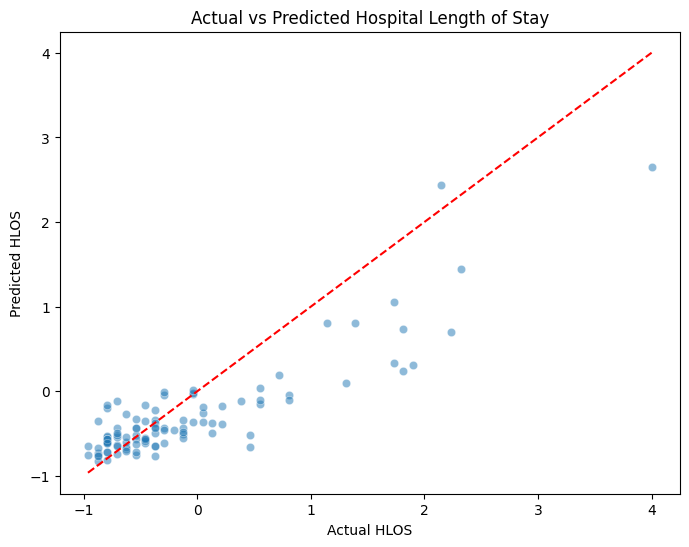

In [131]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_test_pred, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.title('Actual vs Predicted Hospital Length of Stay')
plt.xlabel('Actual HLOS')
plt.ylabel('Predicted HLOS')
plt.show()

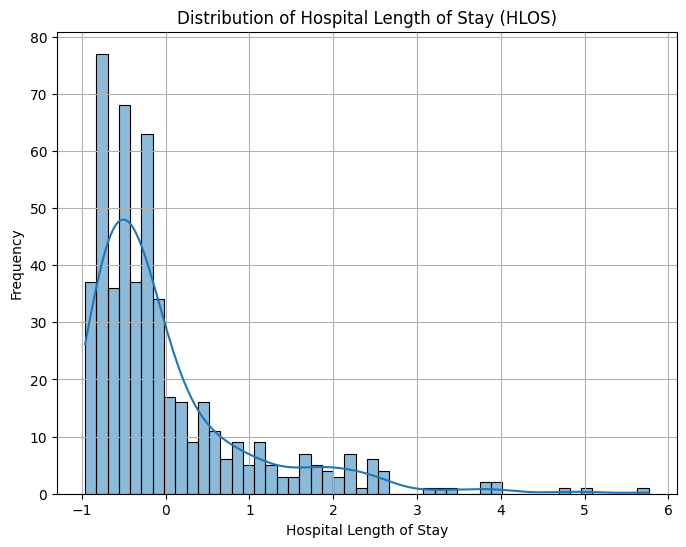

In [168]:
plt.figure(figsize=(8, 6))
sns.histplot(hospital_df['hospital_length_of_stay'], bins=50, kde=True)
plt.title('Distribution of Hospital Length of Stay (HLOS)')
plt.xlabel('Hospital Length of Stay')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


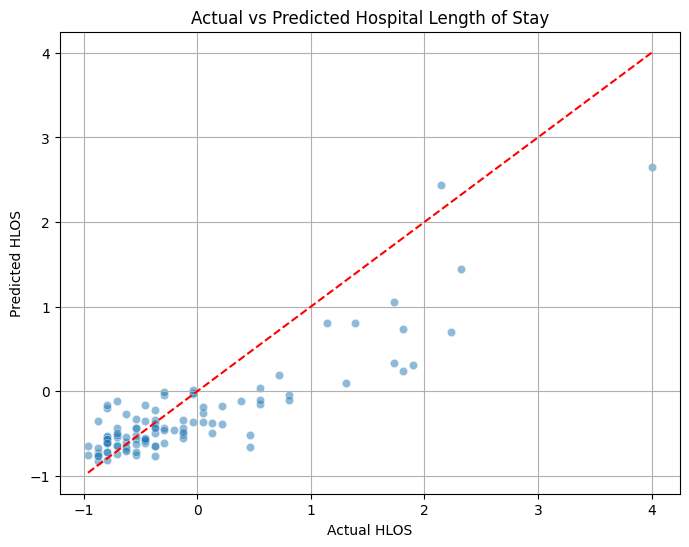

In [170]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_actual, y=y_test_pred, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Hospital Length of Stay')
plt.xlabel('Actual HLOS')
plt.ylabel('Predicted HLOS')
plt.grid(True)
plt.show()


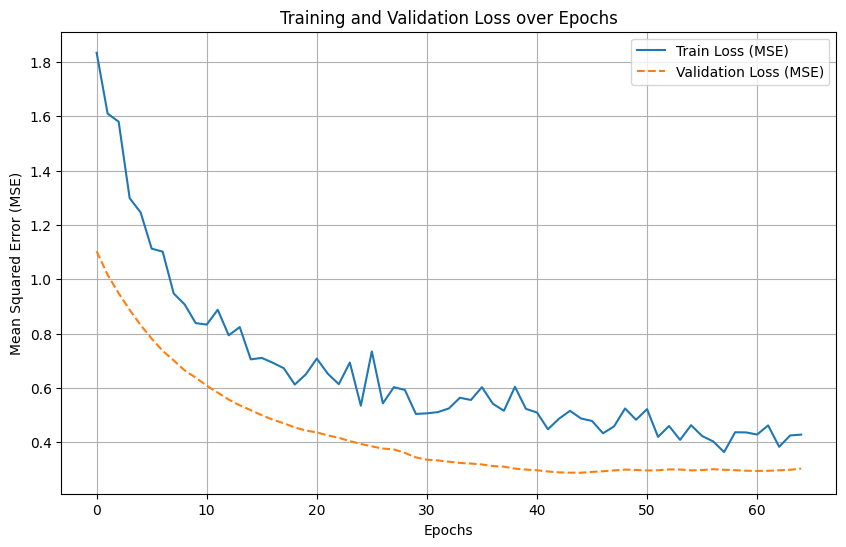

In [171]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linestyle='--')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


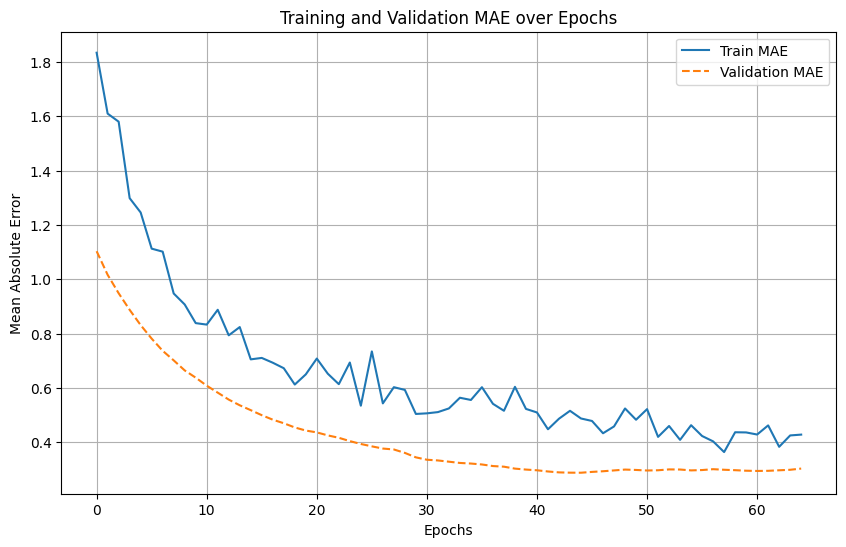

In [172]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mse'], label='Train MAE')
plt.plot(history.history['val_mse'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-174-715d1843db09>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations[top_features], y=top_features, palette='viridis')


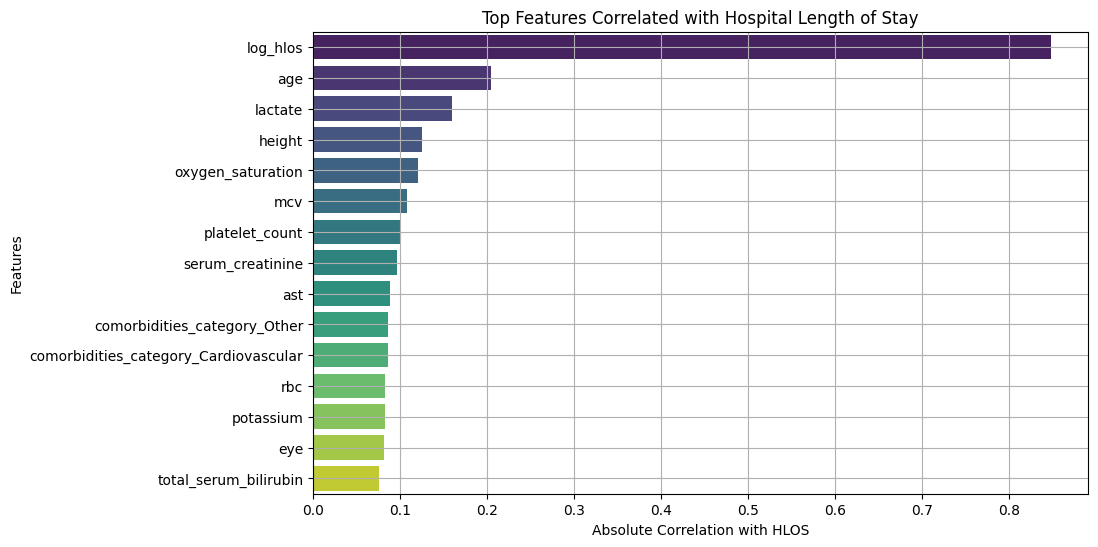

In [174]:
correlations = corr_matrix['hospital_length_of_stay'].abs().sort_values(ascending=False)
top_features = correlations[1:16].index.tolist()
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations[top_features], y=top_features, palette='viridis')
plt.title('Top Features Correlated with Hospital Length of Stay')
plt.xlabel('Absolute Correlation with HLOS')
plt.ylabel('Features')
plt.grid(True)
plt.show()
